# Problem Statement
https://www.kaggle.com/c/dogs-vs-cats/data

There are two zipped files - one for training and one for testing. The training contains images of cat or dog - the files are named accordingly. With the purpose of model building the files in the training have been distributed into directories - training and validation with 70/30 splits by count.   

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

import skimage as ski
import skimage.io


import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from keras.models import Sequential

%matplotlib inline

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data_home = "/data/kaggle/cat-vs-dog/"
files = [data_home + "training/cat/" + fname 
              for fname in os.listdir(data_home + "training/cat/")]
files += [data_home + "training/dog/" + fname
              for fname in os.listdir(data_home + "training/dog/")]
files = np.array(files)

In [4]:
files

array(['/data/kaggle/cat-vs-dog/training/cat/cat.0.jpg',
       '/data/kaggle/cat-vs-dog/training/cat/cat.1.jpg',
       '/data/kaggle/cat-vs-dog/training/cat/cat.10.jpg', ...,
       '/data/kaggle/cat-vs-dog/training/dog/dog.9997.jpg',
       '/data/kaggle/cat-vs-dog/training/dog/dog.9998.jpg',
       '/data/kaggle/cat-vs-dog/training/dog/dog.9999.jpg'], dtype='<U50')

In [5]:
y = np.array([1 if "/cat/" in path else 0 for path in files])

In [6]:
pd.Series(y).value_counts()

1    8788
0    8712
dtype: int64

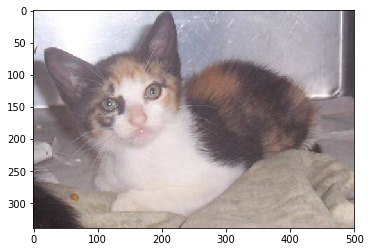

In [7]:
path = files[15]
img = ski.io.imread(path)
plt.imshow(img)

In [9]:
img.shape

(339, 500, 3)

In [8]:
sizes = set()
for i, fname in enumerate(files[:10]):
    img = ski.io.imread(fname)
    sizes.add(img.shape)
sizes

{(149, 150, 3),
 (239, 320, 3),
 (280, 300, 3),
 (300, 219, 3),
 (320, 460, 3),
 (374, 500, 3),
 (375, 499, 3),
 (499, 403, 3),
 (499, 489, 3)}

# Show cat pictures

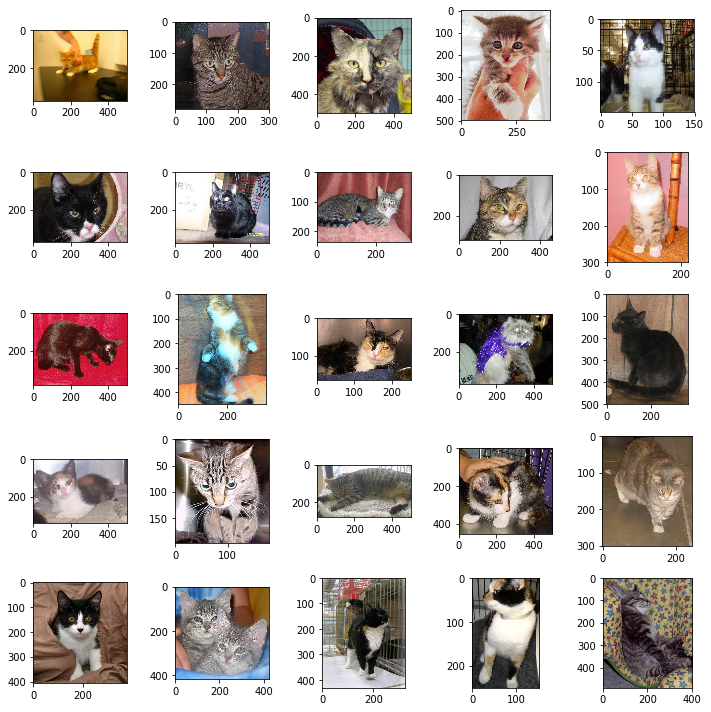

In [9]:
fig, _ = plt.subplots(5, 5, figsize = (10, 10))
plt.tight_layout()

for i, ax in enumerate(fig.axes):
    file = files[y==1][i]
    ax.imshow(ski.io.imread(file))

# Show dig pictures

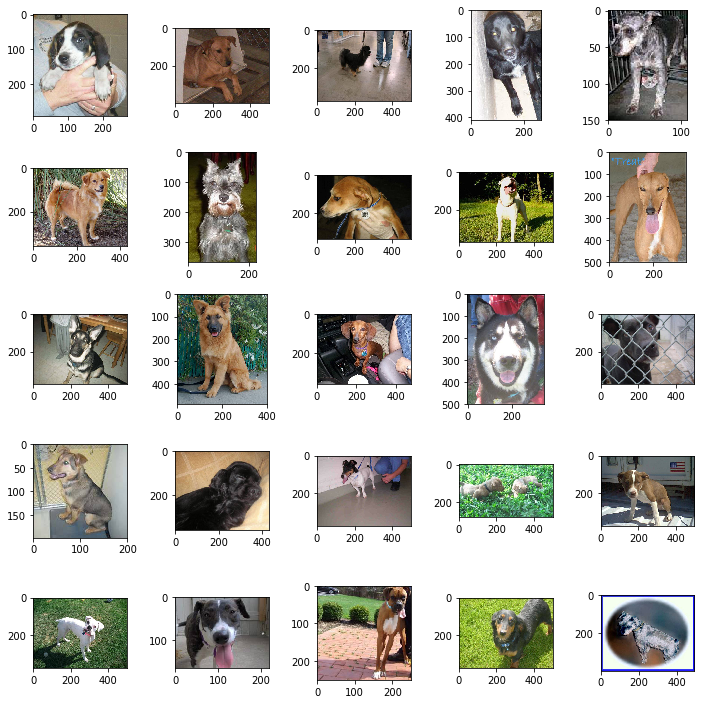

In [10]:
fig, _ = plt.subplots(5, 5, figsize = (10, 10))
plt.tight_layout()

for i, ax in enumerate(fig.axes):
    file = files[y==0][i]
    ax.imshow(ski.io.imread(file))

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a - rotation or a width/height shift.

In [12]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [13]:
img = load_img(files[100], target_size=(150, 150, 3))  # this is a PIL image
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 150, 150, 3)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0

preview_path = "/tmp/cat-vs-dog/preview/"
os.makedirs(preview_path, exist_ok=True)

for batch in datagen.flow(x
                          , batch_size=1
                          , save_to_dir= preview_path
                          , save_prefix='cat'
                          , save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [14]:
x.shape

(1, 150, 150, 3)

In [15]:
batch_size = 16

train_generator = datagen.flow_from_directory(
        data_home + 'training',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

# this is the augmentation configuration we will use for testing only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        data_home + 'validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [17]:
model = Sequential()
model.add(InputLayer((150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
__________

In [18]:
model.fit_generator(
        train_generator,
        steps_per_epoch= 25000 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=10)

Epoch 1/10
1562/1562 [==============================] - 757s 485ms/step - loss: 0.6861 - acc: 0.5513 - val_loss: 0.6604 - val_acc: 0.6500
Epoch 2/10
1562/1562 [==============================] - 749s 480ms/step - loss: 0.6622 - acc: 0.6091 - val_loss: 0.5812 - val_acc: 0.6625
Epoch 3/10
1562/1562 [==============================] - 750s 480ms/step - loss: 0.6337 - acc: 0.6467 - val_loss: 0.5462 - val_acc: 0.6875
Epoch 4/10
1562/1562 [==============================] - 750s 480ms/step - loss: 0.6048 - acc: 0.6809 - val_loss: 0.4902 - val_acc: 0.7562
Epoch 5/10
1562/1562 [==============================] - 750s 480ms/step - loss: 0.5763 - acc: 0.7023 - val_loss: 0.4805 - val_acc: 0.7438
Epoch 6/10
1562/1562 [==============================] - 753s 482ms/step - loss: 0.5572 - acc: 0.7235 - val_loss: 0.4685 - val_acc: 0.7750
Epoch 7/10
1562/1562 [==============================] - 753s 482ms/step - loss: 0.5479 - acc: 0.7284 - val_loss: 0.4795 - val_acc: 0.7688
Epoch 8/10
1562/1562 [============

In [ ]:
model.save("/tmp/cat-vs-dog.h5")